In [3]:
import pandas as pd
import warnings
import datetime as dt
from IPython.display import Image, display

warnings.filterwarnings('ignore')
NOW = dt.datetime(2014,12,31)

In [4]:
flat_data = pd.read_csv('sample-orders.csv',sep=';', encoding = 'iso-8859-1')
flat_data[flat_data['customer'] == 'Aaron Bergman']

,order_date,order_id,customer,grand_total,customer_id
624,2/19/11,CA-2011-152905,Aaron Bergman,13,3
665,03/07/2011,CA-2011-156587,Aaron Bergman,310,2
2336,11/11/2013,CA-2013-140935,Aaron Bergman,564,2


In [5]:
# correct the data
# Make the date_placed column datetime
flat_data['order_date'] = pd.to_datetime(flat_data['order_date'])
    
rfmTable = flat_data.groupby(['customer', 'customer_id']).agg({
            'order_date': lambda x: (NOW - x.max()).days, # Recency
            'order_id': lambda x: x.count(),      # Frequency
            'grand_total': lambda x: x.sum()}) # Monetary Value

rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'},inplace=True)


rfmTable.head(5)

recency  frequency  monetary_value
customer        customer_id                                    
Aaron Bergman   2                415          2             874
                3               1411          1              13
Aaron Hawkins   2                 12          7            1744
Aaron Smayling  2                 88          7            3050
Adam Bellavance 2                 54          8            7756

In [6]:
quantiles = rfmTable.quantile(q=[0.20, 0.4, 0.6, 0.8])
quantiles.head(5)

,recency,frequency,monetary_value
0.2,26.0,4.0,934.4
0.4,54.0,5.0,1729.4
0.6,105.0,7.0,2726.2
0.8,235.2,8.0,4270.8


In [13]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
    
rfmTable['r_quartile'] = rfmTable['recency'].apply(RScore, args=('recency', quantiles,))
rfmTable['f_quartile'] = rfmTable['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfmTable['m_quartile'] = rfmTable['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

rfmTable['RFMScore'] = rfmTable['r_quartile'] *100 + rfmTable['f_quartile'] *10 + rfmTable['m_quartile']
rfmTable['total_score'] = rfmTable['r_quartile'] + rfmTable['f_quartile'] + rfmTable['m_quartile']

rfmTable[rfmTable['RFMScore'] == 555].sort_values('monetary_value', ascending=False).head(10)

,,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,total_score
customer,customer_id,,,,,,,,
Sanjit Engle,2,9,10,11751,5,5,5,555,15
John Lee,2,21,11,9801,5,5,5,555,15
Pete Kriz,2,9,12,8647,5,5,5,555,15
Harry Marie,2,2,10,8237,5,5,5,555,15
Lena Creighton,2,16,12,7661,5,5,5,555,15
Patrick O'Brill,2,4,11,7474,5,5,5,555,15
Dan Reichenbach,2,3,9,6528,5,5,5,555,15
James Galang,2,1,11,6367,5,5,5,555,15
William Brown,2,20,11,6159,5,5,5,555,15


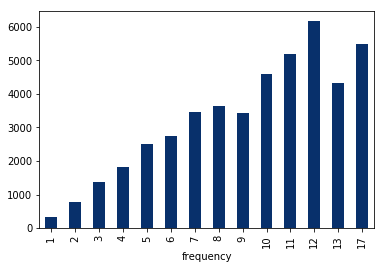

In [14]:
plot_frequency = rfmTable                     \
    .groupby('frequency')  \
    .agg('monetary_value')   \
    .mean()                  \
    .plot(kind='bar', colormap='Blues_r')

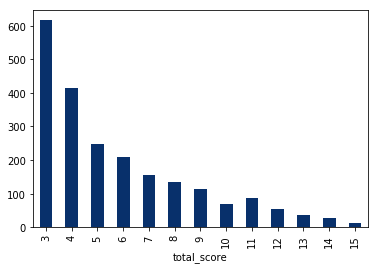

In [34]:
plot_frequency = rfmTable    \
    .groupby('total_score')  \
    .agg('recency')          \
    .mean()                  \
    .plot(kind='bar', colormap='Blues_r')

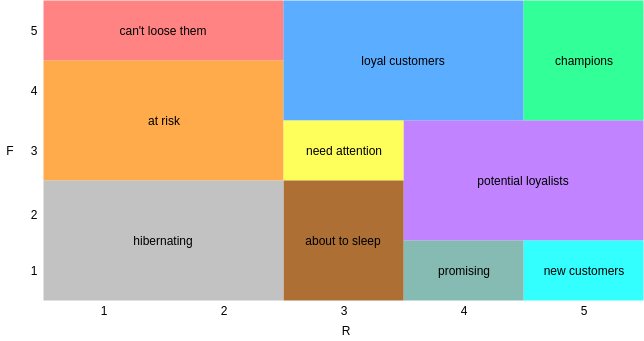

In [35]:
display(Image(filename='rfm-segments.png'))

In [39]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}
rfmTable['segment_id'] = rfmTable['r_quartile'].map(str)  + rfmTable['f_quartile'].map(str)
rfmTable['segment_name'] = rfmTable['segment_id'].replace(segt_map, regex=True)
rfmTable.head(5)

recency  frequency  monetary_value  r_quartile  \
customer        customer_id                                                   
Aaron Bergman   2                415          2             874           1   
                3               1411          1              13           1   
Aaron Hawkins   2                 12          7            1744           5   
Aaron Smayling  2                 88          7            3050           3   
Adam Bellavance 2                 54          8            7756           4   

                             f_quartile  m_quartile  RFMScore  total_score  \
customer        customer_id                                                  
Aaron Bergman   2                     1           1       111            3   
                3                     1           1       111            3   
Aaron Hawkins   2                     3           3       533           11   
Aaron Smayling  2                     3           4       334           10   
Adam Bellavance 2                     4           5       445           13   

                            segment_id         segment_name  
customer        customer_id                                  
Aaron Bergman   2                   11          hibernating  
                3                   11          hibernating  
Aaron Hawkins   2                   53  potential loyalists  
Aaron Smayling  2                   33       need attention  
Adam Bellavance 2                   44      loyal customers

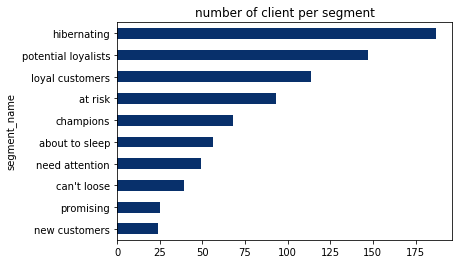

In [37]:
filter
# rfmTable.loc[rfmTable.index.get_level_values('customer') == 'Aaron Bergman']
rfmTable.groupby('segment_name')      \
.agg('segment_id')     \
.count()         \
.sort_values() \
.plot(kind='barh', colormap='Blues_r', title = 'number of client per segment')


In [ ]:
# get all target clients
targ_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][4-3]': 'potential loyalists',
    r'5[1-5]': 'champions'
}

<center> <h3>References</h3> </center>
- https://www.kaggle.com/sarahm/customer-segmentation-using-rfm-analysis